In [1]:
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

Welcome to JupyROOT 6.18/04


In [2]:
REBUILD_DATA = False

class ProtonVsAlpha():
    def __init__(self, FILENAME, MIN_ENERGY, N_EVENTS, CHANNELS):
        self.filename = FILENAME
        self.min_energy = MIN_ENERGY
        self.n_events = N_EVENTS
        self.channels = CHANNELS
    
    PROTON = "p" # risetime ranges for discrimination
    ALPHA = "a"
    LABELS = {PROTON:0, ALPHA:1}
    training_data = []
    alphacount = 0
    protoncount = 0
    
    def make_training_data(self):
        rf = rt.TFile(self.filename, "read")
        evt_tree = rf.Get("ggpData")
        x=0
        print("Reading the events on channels:",self.channels )
        for i, evt in enumerate(evt_tree):
            if (evt.channel in self.channels) & (x<self.n_events) & (evt.energy>self.min_energy):
                if ((evt.riseTime>int(10)) & (evt.riseTime<int(30))): #this should be a proton
                    self.training_data.append([(np.frombuffer(evt.samples, dtype = "f" )) - evt.baseline, 
                                                   np.eye(2)[self.LABELS["p"]] ])
                    self.protoncount +=1
                elif (evt.riseTime>int(30)):
                    self.training_data.append([(np.frombuffer(evt.samples, dtype = "f" )) - evt.baseline, 
                                                   np.eye(2)[self.LABELS["a"]] ])
                    self.alphacount +=1
                x+=1
            if (x>self.n_events):
                break
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Protons:", self.protoncount)
        print("Alphas:", self.alphacount)

                
        
        
    
    
    

In [3]:
if REBUILD_DATA:
    protonvsalpha = ProtonVsAlpha("run_4024.root",400,10000,[23,24,25])
    protonvsalpha.make_training_data()

In [4]:
training_data = np.load("training_data.npy", allow_pickle = True)

In [5]:
print(len(training_data))

1625


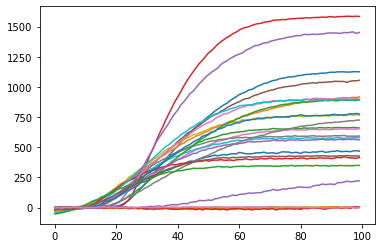

In [6]:
for i in range(100):
    if training_data[i][1][1]==1:
        plt.plot(training_data[i][0])

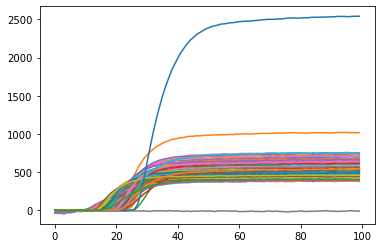

In [7]:
for i in range(100):
    if training_data[i][1][1]==0:
        plt.plot(training_data[i][0])

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
)


In [22]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 100)
X = X/3000.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

162


In [23]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

1463
162


In [4]:
def train(net):
    BATCH_SIZE = 50
    EPOCHS = 3

    for epoch in range(EPOCHS):
        for i in tqdm(range(0,len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,100)
            batch_y = train_y[i:i+BATCH_SIZE]
        
            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch: {epoch}. Loss: {loss}")


def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1, 100))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            #else: 
            #    plt.plot(test_X[i])
            #   print(real_class)
            total += 1

    print("Accuracy: ", round(correct/total, 3))




In [28]:
train(net)

100%|██████████| 30/30 [00:00<00:00, 507.80it/s]

Epoch: 0. Loss: 0.1654776930809021
Epoch: 1. Loss: 0.04254333674907684
Epoch: 2. Loss: 0.0020051109604537487


100%|██████████| 162/162 [00:00<00:00, 1812.24it/s]


tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
Accuracy:  0.938


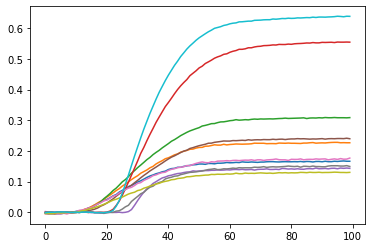

In [34]:
test(net)